# Inverse problem of the reconstruction of the Neumann BCs for Laplace's equation

__Formulation of Inverse Problem__

__Direct Problem__
- Equation: $A * x = f$
- $A$: Matrix of Direct Problem
  - shape: ($\text{dof}$, $\text{dof}$)
- $x$: Solution of Direct Problem
  - shape: ($\text{dof}$)
- $f$: Load Vector of Direct Problem
  - shape: ($\text{dof}$)
- $F$: Projection Matrix from Normal Derivative in given points (Mass Matrix over Boundary Elements)
  - shape: ($\text{dof}$, $g$)

__Inverse Problem__
- Equation: $M * y = \text{grad}$
- $M$: Resulting Matrix of Inverse Problem
  - shape: ($3p$, $\text{dof}$)
- $y$: Normal Derivative in Boundary Points
- $\text{grad}$: Concatenation of Grad Vectors ($\text{grad}_x, \text{grad}_y, \text{grad}_z$)

__Additional Variables__
- $P_x, P_y, P_z$: Projection Matrices from Solution to Partial Derivative
  - shape: ($p$, $\text{dof}$)
- $M_x = P_x \times A^{-1} \times F$: Need batching with Direct Solvers (spsolve or better factorized to reduce amount of time)
  - Note: $A$ is singular, so we need to be careful with solving the system
- $M = (M_x, M_y, M_z)$: Concatenation of Inverse Problem Matrices
- $\text{dof}$: Degrees of Freedom of Direct Problem
- $p$: Number of Measuring Points
- $g$: Number of Boundary Points with Known Normal Derivative (Is it all boundary points?)

__About calculating M__

Computing $M$ consists of solving a lot of systems of linear equations:

$$A^{-1} * F = X$$

is same with solving SLAE with matrix rhs:

$$AX = F$$

Result of this multipication can be a big dense (90% density) matrix so we should solve SLAE with one or several columns form $F$.

Probable algorithm for getting $M$ (Under investigation, because it gives big error (e.g. `1e-2` instead of `1e-11`))

```python
for f in F:

  x = spsolve(A, f) # f.shape: (dof, 1)
  
  Mx[i] = P_x @ x
```

__Questions__

1. How to deal with $A$ is singular? It affects calculation of $M$.

2. How to assemble $F$, if we have rhs (source) in direct problem? (If equation is not Laplace's)

## Preprocessing

Import the required libraries

In [1]:
import numpy as np
import scipy as sp
import cupy as cp
import cupy.sparse.linalg as cpsl

from tqdm import tqdm

import pyquasar as pq

np.set_printoptions(precision=15, suppress=False)
sp.sparse.linalg.use_solver(useUmfpack=False)

import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib.ticker as ticker
import matplotlib

font_path = "/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf"
italic_path = "/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman_Italic.ttf"

font_manager.fontManager.addfont(font_path)
font_manager.fontManager.addfont(italic_path)

plt.rcParams["font.serif"] = ["Times New Roman", "Times New Roman Italic"]

In [2]:
plt.rcParams.update(
  {
    "figure.figsize": (6, 6),
    "axes.facecolor": "none",
    "font.size": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "mathtext.it": "serif:italic",
    "mathtext.fontset": "custom",
    "mathtext.rm": "Times New Roman",
    "font.family": "Times New Roman"
  }
)

%config InlineBackend.figure_format='retina'

In [3]:
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["mathtext.rm"] = "Times New Roman"
plt.rcParams["font.family"] = "Times New Roman"

Load the `.geo` file and generate the mesh for the problem using GMSH.

`refine_k` is the number of times the mesh is refined.

In [4]:
mesh = pq.Mesh.load("circle_splitted.msh", basis_order=2, refine_k=0)

mesh

<Mesh object summary 
	Numeration: global
	Domains: [<MeshDomain object summary
	Material: air
	Total elements number: 10752
	Element type: Tetrahedron 10 NC; Count: 10752
	Boundary type: neumann; Tag: 4; Element type: Triangle 6 NC; Count: 2048.
	Boundary type: neumann; Tag: 5; Element type: Triangle 6 NC; Count: 224.
	Boundary type: neumann; Tag: 6; Element type: Triangle 6 NC; Count: 224.
>]>

In [5]:
# mesh.domains[0].vertices[..., 2] = mesh.domains[0].vertices[..., 2] + 1.6
mesh.domains[0].vertices[..., 2].min()

-1.6

## Direct Problem

Assemble & solve the direct problem to obtain problem matrix, load vector and the solution `u`.

Note that mesh consists of only Neumann boundary conditions and therefore the solution `u` is need to be orthogonalized.

In [6]:
# Define the materials dictionary
materials = {
    "air": {"air": 0},
}

# Create a list of FemDomain objects from the mesh domains
domains = [pq.FemDomain(domain) for domain in mesh.domains]

# Create a FemProblem object with the domains
problem = pq.FemProblem(domains)

# Assemble the problem using the materials dictionary
problem.assembly(materials, batch_size=1024)

problem._matrix = problem._matrix.tocsr()
problem.matrix.data[problem.matrix.indptr[-2] : problem.matrix.indptr[-1]] = 0
problem._matrix = problem._matrix.tocsc()
problem.matrix.data[problem.matrix.indptr[-2] : problem.matrix.indptr[-1]] = 0
problem._matrix[-1, -1] = 1
problem._matrix.eliminate_zeros()

# Print the degree of freedom count
print(f"DOF: {problem.dof_count}")

DOF: 16929


## Inverse Problem

Get points of interest

In [7]:
datapath = "data/surface.npz"
train_data = np.load(datapath)

train_xs = train_data["xs"]
train_ys = train_data["ys"]
train_zs = train_data["zs"]

grad_x = train_data["grad_x"]
grad_y = train_data["grad_y"]
grad_z = train_data["grad_z"]

train_data.close()

grad = np.concatenate([grad_x, grad_y, grad_z])
grad_cp = cp.array(grad)

pts = np.concatenate([train_xs[:, None], train_ys[:, None], train_zs[:, None]], axis=1)
pts.shape

(12800, 3)

In [8]:
pts[:, 2].min()

-1.5

Project the solution gradient into the points of interest

In [9]:
proj_grad = problem.project_grad_into(cp.asarray(pts), batch_size=256)

100%|██████████| 50/50 [00:00<00:00, 62.08it/s]


Get the Mass matrix over the Neumann type boundary

In [10]:
F = problem.mass_boundary(["neumann"])
F_cp = cp.sparse.csc_matrix(F)

Initialize the inverse problem matrix

In [11]:
M_cp = cp.zeros((3 * pts.shape[0], F.shape[1]))

Get factorization of direct problem matrix

In [12]:
lu_cp = cp.sparse.linalg.splu(cp.sparse.csc_matrix(problem.matrix))

Iteratively calculate the inverse problem matrix

In [13]:
proj_grad_cp = (
    cp.sparse.csr_matrix(proj_grad[0]),
    cp.sparse.csr_matrix(proj_grad[1]),
    cp.sparse.csr_matrix(proj_grad[2]),
)

In [14]:
batch_size = 256
num_batches = F_cp.shape[1] // batch_size

if F_cp.shape[1] % batch_size != 0:
    num_batches += 1

for i in tqdm(range(num_batches)):
    sol = lu_cp.solve(F_cp.T[i * batch_size : (i + 1) * batch_size].T.toarray())
    M_cp[:, i * batch_size : (i + 1) * batch_size] = cp.concatenate(
        [proj_grad_cp[0] @ sol, proj_grad_cp[1] @ sol, proj_grad_cp[2] @ sol]
    )

100%|██████████| 20/20 [00:01<00:00, 15.89it/s]


Iteratively calculate the inverse problem solution

In [15]:
res_flow_cp, istop, itn, normr, normar = cpsl.lsmr(
    M_cp, grad_cp, atol=1e-15, btol=1e-15, maxiter=10000
)[:5]

rerr = cp.linalg.norm(M_cp @ res_flow_cp - grad_cp) / np.linalg.norm(grad_cp)

print(f"The reason of stopping: {istop}")
print(f"Number of iterations: {itn}")
print(f"Norm of the residual: {normr:.2e}")
print(f"Norm of modified residual: {normar:.2e}")
print(f"Relative error of inverse problem solution (M @ y = grad): {rerr:.2e}")

The reason of stopping: 7
Number of iterations: 10000
Norm of the residual: 7.67e-02
Norm of modified residual: 1.89e-06
Relative error of inverse problem solution (M @ y = grad): 6.35e-04


In [16]:
# pinv_M_cp = cp.linalg.pinv(M_cp, rcond=1e-12)

# res_flow_cp = pinv_M_cp @ grad_cp

# err = cp.linalg.norm(grad_cp - M_cp @ res_flow_cp) / cp.linalg.norm(grad_cp)

# print(f"Norm of invers problem residual: {err:.2e}")

In [17]:
res_flow = cp.asnumpy(res_flow_cp)

Test through direct problem

In [18]:
# Get the kernel for Gram-Schmidt orthogonalization
kernel = problem.domains[0].kernel

# Calculate load vector via inverse problem result flow
problem._load_vector = np.zeros_like(problem._load_vector)
problem._load_vector += F @ res_flow

# Solve the problem
test_sol = problem.solve(atol=1e-15)

# Perform the Gram-Schmidt orthogonalization
test_sol -= kernel[0] * (test_sol @ kernel[0]) / (kernel[0] @ kernel[0])

In [19]:
test_datapath = "data/measurements.npz"
test_data = np.load(test_datapath)

test_xs = test_data["xs"]
test_ys = test_data["ys"]
test_zs = test_data["zs"]


test_true_grad_x = test_data["grad_x"]
test_true_grad_y = test_data["grad_y"]
test_true_grad_z = test_data["grad_z"]

test_data.close()

test_pts = np.concatenate([test_xs[:, None], test_ys[:, None], test_zs[:, None]], axis=1)
test_proj_grad = problem.project_grad_into(cp.asarray(test_pts), batch_size=256)

  0%|          | 0/601 [00:00<?, ?it/s]

100%|██████████| 601/601 [00:02<00:00, 206.00it/s]


In [20]:
surface_test_grad_x = proj_grad[0] @ test_sol
surface_test_grad_y = proj_grad[1] @ test_sol
surface_test_grad_z = proj_grad[2] @ test_sol

surface_diff_x = surface_test_grad_x - grad_x
surface_diff_y = surface_test_grad_y - grad_y
surface_diff_z = surface_test_grad_z - grad_z

In [21]:
pts.shape

(12800, 3)

In [22]:
np.abs(np.concatenate([surface_diff_x, surface_diff_y, surface_diff_z])).max()

0.0030953381597333685

In [23]:
np.abs(surface_diff_x).max(), np.abs(surface_diff_y).max(), np.abs(surface_diff_z).max()

(0.0030953381597333685, 0.0028393679601494692, 0.0025400699292184026)

In [24]:
err = np.sqrt((surface_diff_x**2 + surface_diff_y**2 + surface_diff_z**2) / (surface_diff_x.shape[0]))
print(f"Result error: {err.max():.2e}")

Result error: 3.71e-05


In [25]:
test_grad_x = test_proj_grad[0] @ test_sol
test_grad_y = test_proj_grad[1] @ test_sol
test_grad_z = test_proj_grad[2] @ test_sol

diff_x = test_grad_x - test_true_grad_x
diff_y = test_grad_y - test_true_grad_y
diff_z = test_grad_z - test_true_grad_z

In [26]:
np.abs(np.concatenate([diff_x, diff_y, diff_z])).max()

0.008263473137683497

In [27]:
# data = np.loadtxt("/content/Measurements", delimiter="\t")
# Bmap = {(np.round(x[0], 3), np.round(x[1], 3), np.round(x[2], 3)): x[3:] for x in data}


# def B(x, y, z):
#   def find(x, y, z):
#     bx, by, bz = Bmap[(np.round(x, 3), np.round(y, 3), np.round(z, 3))]
#     return bx, by, bz

#   find = np.frompyfunc(find, 3, 3)
#   bx, by, bz = find(x, y, z)
#   return bx.astype(np.float64), by.astype(np.float64), bz.astype(np.float64)

In [28]:
graph_ids = np.argwhere((test_pts[:, 1] == 0) & (test_pts[:, 0] == 0))
graph_dx = test_grad_x[graph_ids]
graph_dy = test_grad_y[graph_ids]
graph_dz = test_grad_z[graph_ids]
graph_pts = test_pts[graph_ids].reshape(-1, 3)
graph_tdx = test_true_grad_x[graph_ids]
graph_tdy = test_true_grad_y[graph_ids]
graph_tdz = test_true_grad_z[graph_ids]
rerr = np.sqrt(
    (graph_dx - graph_tdx) ** 2
    + (graph_dy - graph_tdy) ** 2
    + (graph_dz - graph_tdz) ** 2
)
pz = graph_pts[:, 2]

In [29]:
plt.rcParams["text.usetex"] = False

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


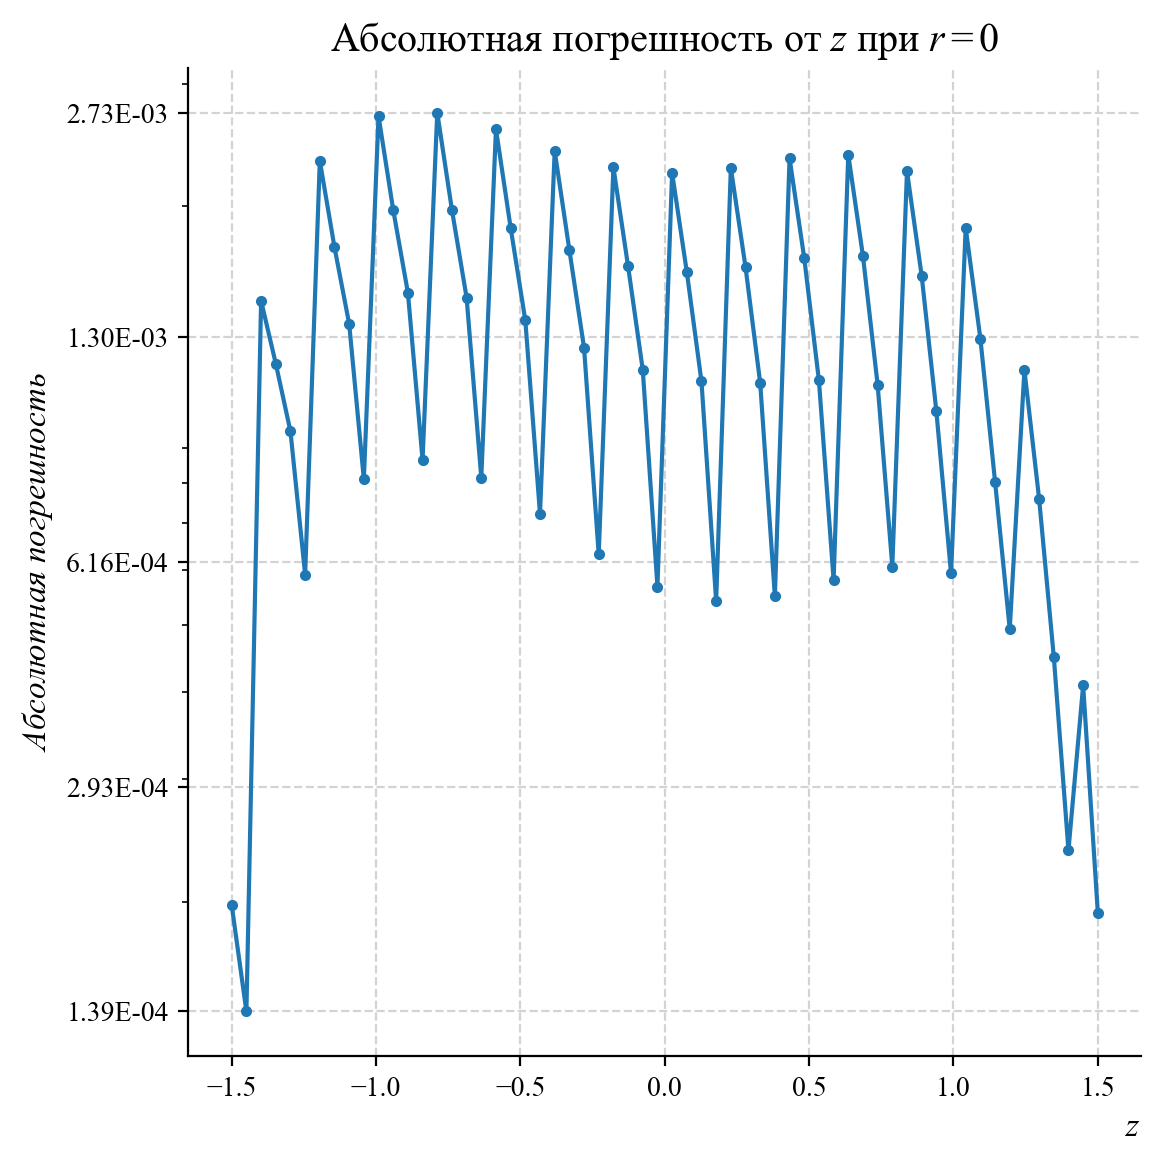

In [30]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import matplotlib

fig, ax = plt.subplots()

ax.plot(pz, rerr, linestyle="-", marker=".")

ax.set_yscale("log")
ax.set_xlabel(r"$z$", loc="right")
ax.set_ylabel(r"$\it{Абсолютная\ погрешность}$")

ax.set_title(r"Абсолютная погрешность от $z$ при $r=0$")
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

tick_locs = np.logspace(np.log10(rerr.min()), np.log10(rerr.max()), 5)
tick_labels = ["{:.2E}".format(t) for t in tick_locs]

ax.yaxis.set_major_locator(ticker.FixedLocator(tick_locs))
ax.yaxis.set_major_formatter(ticker.FixedFormatter(tick_labels))

ax.grid(color="lightgray", linestyle="--")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.savefig(
    "test_relative_error.pdf",
    bbox_inches="tight",
    dpi=300,
    format="pdf",
    transparent=True,
)
plt.show()

In [31]:
err = np.sqrt(np.mean(surface_diff_x**2 + surface_diff_y**2 + surface_diff_z**2))
print(f"Result error: {err.max():.2e}")

Result error: 6.78e-04
